# Bayesian Linear Regression part 3: Posterior


Now I have [priors on the weights]({% post_url 2018-01-03-bayesian-linreg %}) and [observations]({% post_url 2018-01-08-bayesian-linreg-sample %}). In this post, I'll show a formula for finding the posterior on the weights, and show one plot using it. The [next post]({% post_url 2018-01-10-bayesian-linreg-plots %}) will have more plots.

My goal is to find the distribution of the weights given the data. This is given by

$$p(\mathbf w | \mathcal D) = \frac{p(\mathcal D | \mathbf w)p(\mathbf w)}{p(\mathcal D)}.$$

Since I'm assuming the prior is Gaussian and likelihood is a combination of Gaussians, the posterior will also be Gaussian. That means there is a [closed form expression](https://en.wikipedia.org/wiki/Conjugate_prior)
for the mean and covariance of the posterior. Skipping ahead, I can use the equations from ["Computing the Posterior" in the class notes](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/w6c_bayesian_regression.html#computing-the-posterior):

$$\begin{aligned}
    V_N &= \sigma_y^2(\sigma_y^2V_0^{-1} + \Phi^\top \Phi)^{-1}\\
    \textbf w_N &= V_N V_0^{-1}\textbf w_0 + \frac{1}{\sigma_y^2}V_N \Phi^\top\textbf y.
\end{aligned}$$

## Code

I'll convert this to code. Heads up, I know this isn't the most efficient way to do this. I'll try to update this when I find more tricks.


In [1]:
# imports!
import numpy as np
import matplotlib.pyplot as plt

# helper functions you can skip over :D
SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

### Variables

\\( w_0 \\) and \\( V_0 \\) are the prior's mean and variance, which I defined back in [priors on the weights](2018-01-03-bayesian-linreg.ipynb). The code for that was

In [2]:
mu_w = 0
mu_b = 0

sigma_w = 0.2
sigma_b = 0.2

w_0 = np.hstack([mu_b, mu_w])
V_0 = np.diag([sigma_b, sigma_w])**2

\\(V_0^{-1}\\) is the inverse of the prior's variance. It shows up a few times, so I'll
compute it once. It doesn't look like I can use `np.linalg.solve` on it, so I'll use
`np.linalg.inv`:

In [3]:
V0_inv = np.linalg.inv(V_0)

\\(\Phi\\) is the augmented input matrix. In this case, it's the `x` values of the [observations](2018-01-08-bayesian-linreg-sample.ipynb), with the column of 1s I add to deal with the bias term. So, from [the last post](2018-01-08-bayesian-linreg-sample.ipynb), I had `x` as

In [4]:
X_in = 2 * np.random.rand(21, 1) - 1


Then \\(\Phi\\) is


In [5]:
Phi_X_in = np.hstack((
    np.ones((X_in.shape[0], 1)),  # pad with 1s for the bias term
    X_in
))

\\(\textbf y\\) is also from [the last post]({% post_url 2018-01-08-bayesian-linreg-sample %}). It's the vector containing all the observations.
 The code used there was

In [6]:
true_w = np.array([[2, 0.3]]).T

def f(x):
    x_bias = np.hstack((
        np.ones((x.shape[0], 1)),  # pad with 1s for the bias term
        x
    ))

    return x_bias @ true_w

true_sigma_y = 0.1
noise = true_sigma_y * np.random.randn(X_in.shape[0], 1)

y = f(X_in) + noise


But since I already have \\(\Phi\\), I'll skip the function and just use

In [7]:
y = Phi_X_in @ true_w + noise


\\(\sigma_y\\) is my guess of `true_sigma_y`. On a real dataset, I might not know the true \\(\sigma_y\\), so I keep separate `true_sigma_y` and `sigma_y` constants that I can use to explore what happens if my guess is off. I'll start with imagining I know it

In [8]:
sigma_y = true_sigma_y


The rest is a matter of copying the equation over correctly and hoping I got it right!

In [9]:
V_n = sigma_y**2 * np.linalg.inv(sigma_y**2 * V0_inv + (Phi_X_in.T @ Phi_X_in))
w_n = V_n @ V0_inv @ w_0 + 1 / (sigma_y**2) * V_n @ Phi_X_in.T @ y

### Complete code

Putting it all together, I get

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the prior
mu_w = 0
mu_b = 0

sigma_w = 0.2
sigma_b = 0.2

w_0 = np.hstack([mu_b, mu_w])[:, None]
V_0 = np.diag([sigma_b, sigma_w])**2

# Get observations
true_sigma_y = 0.1
true_w = np.array([[2, 0.3]]).T

X_in = 2 * np.random.rand(11, 1) - 1

Phi_X_in = np.hstack((
    np.ones((X_in.shape[0], 1)),  # pad with 1s for the bias term
    X_in
))

true_sigma_y = 0.05
noise = true_sigma_y * np.random.randn(X_in.shape[0], 1)

y = Phi_X_in @ true_w + noise

# Compute the posterior
sigma_y = true_sigma_y  # I'm going to guess the noise correctly

V0_inv = np.linalg.inv(V_0)
V_n = sigma_y**2 * np.linalg.inv(sigma_y**2 * V0_inv + (Phi_X_in.T @ Phi_X_in))
w_n = V_n @ V0_inv @ w_0 + 1 / (sigma_y**2) * V_n @ Phi_X_in.T @ y

Sweet! Now it seems like after doing all that code and math, I should be rewarded with pretty graphs!

## Plotting

In this post, I'll just show one graph. `w_n` is the mean guess of the weights, so I can plot that function. I can also compare it to the weights from
least squares and the true weights.

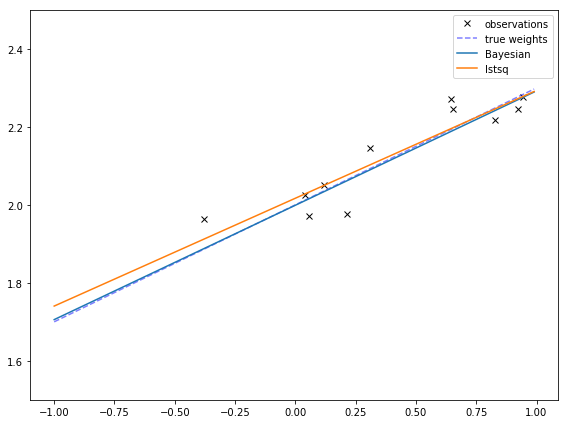

In [21]:
grid_size = 0.01
x_grid = np.arange(-1, 1, grid_size)[:, None]

Phi_X = np.hstack((
    np.ones((x_grid.shape[0], 1)),  # pad with 1s for the bias term
    x_grid
))

lsqsq_w = np.linalg.lstsq(Phi_X_in, y)[0]

plt.clf()
plt.figure(figsize=(8, 6))
plt.plot(X_in, y, 'xk', label='observations')
plt.plot(x_grid, Phi_X @ true_w, '--b', alpha=0.5, label='true weights')
plt.plot(x_grid, Phi_X @ w_n, label='Bayesian')
plt.plot(x_grid, Phi_X @ lsqsq_w, label='lstsq')
plt.legend()
plt.ylim([1.5, 2.5])
maybe_save_plot('2018-01-09-mean')  # Graph showing three lines, all near each other, going through the points.
plt.show()


These are pretty similar! They are different at least in part due to the prior, which are centered at 0, meaning that it expects most lines to go through the origin and have a slope of 0.

This is more obvious if I make the true bias is very far away from 0. Then the Bayesian fit might not even go through the points! This might remind you of the effects of regularization, which makes extreme values less likely, at the cost of sometimes having poorer fits.

In [12]:
true_w = np.array([[100, 0.3]]).T

![Graph showing three lines, two near each other going through the points, and one closer to 0.](images/2018-01-09-mean-far-away.png)


### [Next](2018-01-10-bayesian-linreg-plots.ipynb)

## See Also

 - Still thanks to [MLPR](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/)!
 - Wikipedia on [Conjugate Priors](https://en.wikipedia.org/wiki/Conjugate_prior)
